# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1YRAEOYBMbpTCBjAqZOjiY0FSGyQuTvfz#scrollTo=SwyDuiuUqIDv

In [63]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))


<IPython.core.display.Javascript object>

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [33]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [34]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

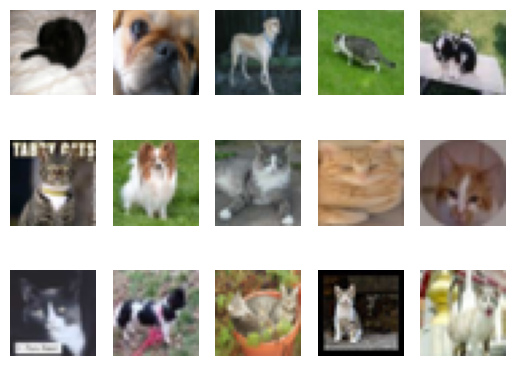

In [35]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [36]:
print("There are", len(train_loader), "training,", len(val_loader), "validation, and", len(test_loader), "test examples.")

There are 8000 training, 2000 validation, and 2000 test examples.


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [37]:
# If we judge the performance based on the loss of the training set, we may run into the issue of overfitting
# the model because the model will be limited to only the training set. This is why we need a validation set
# to train our model because it can verify the performance of the model trained using the training set on
# a new set of data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [38]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [39]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [40]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [41]:
size_small = 0
size_large = 0
for param in small_net.parameters():
    size_small += torch.numel(param)
for param in large_net.parameters():
    size_large += torch.numel(param)
print(size_small, "parameters in small_net.")
print(size_large, "parameters in large_net.")
    #print(param.shape)

386 parameters in small_net.
9705 parameters in large_net.


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [42]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

In [43]:
# The default values of the parameters, respectively, are 64, 0.01 and 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [44]:
train_net(small_net, 64, 0.01, 5)
# The files written to disk are the CSV files containing the training and validation accuracy and loss, specifically
# model_small_bs64_lr0.01_epoch0
# model_small_bs64_lr0.01_epoch1
# model_small_bs64_lr0.01_epoch2
# model_small_bs64_lr0.01_epoch3
# model_small_bs64_lr0.01_epoch4
# model_small_bs64_lr0.01_epoch4_train_err.csv
# model_small_bs64_lr0.01_epoch4_train_loss.csv
# model_small_bs64_lr0.01_epoch4_val_err.csv
# model_small_bs64_lr0.01_epoch4_val_loss.csv

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6745109295845032 |Validation err: 0.384, Validation loss: 0.6617536786943674
Epoch 2: Train err: 0.36975, Train loss: 0.6493947138786316 |Validation err: 0.3795, Validation loss: 0.6536327060312033
Epoch 3: Train err: 0.358375, Train loss: 0.6382256054878235 |Validation err: 0.3495, Validation loss: 0.6302366033196449
Epoch 4: Train err: 0.345625, Train loss: 0.6248879203796387 |Validation err: 0.37, Validation loss: 0.6313521321862936
Epoch 5: Train err: 0.339, Train loss: 0.6168810434341431 |Validation err: 0.336, Validation loss: 0.6225708574056625
Finished Training
Total time elapsed: 26.27 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [45]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# training small network with default parameters
train_net(small_net, 64, 0.01, 30)

# training large network with default parameters
train_net(large_net, 64, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.331875, Train loss: 0.6086602621078491 |Validation err: 0.341, Validation loss: 0.6210209224373102
Epoch 2: Train err: 0.322875, Train loss: 0.6018914966583252 |Validation err: 0.3345, Validation loss: 0.6205422300845385
Epoch 3: Train err: 0.326375, Train loss: 0.6020211663246154 |Validation err: 0.34, Validation loss: 0.6148599162697792
Epoch 4: Train err: 0.318625, Train loss: 0.5966595168113709 |Validation err: 0.351, Validation loss: 0.6203459100797772
Epoch 5: Train err: 0.31275, Train loss: 0.5917007746696472 |Validation err: 0.334, Validation loss: 0.6120430268347263
Epoch 6: Train err: 0.309, Train loss: 0.5866505696773529 |Validation err: 0.3325, Validation loss: 0.613035224378109
Epoch 7: Train err: 0.31325, Train loss: 0.5857378356456756 |Validation err: 0.3275, Validation loss: 0.6099967435002327
Epoch 8: Train err: 0.30775, Train loss: 0.5802706477642059 |Validation err: 0.32

In [47]:
# The small network took 148.65 seconds to train, whereas the large network took 164.33 seconds to train.
# The large network took longer to train because it has a drastically large amount of parameters in comparison (as seen in part 2a)
# to the small network.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

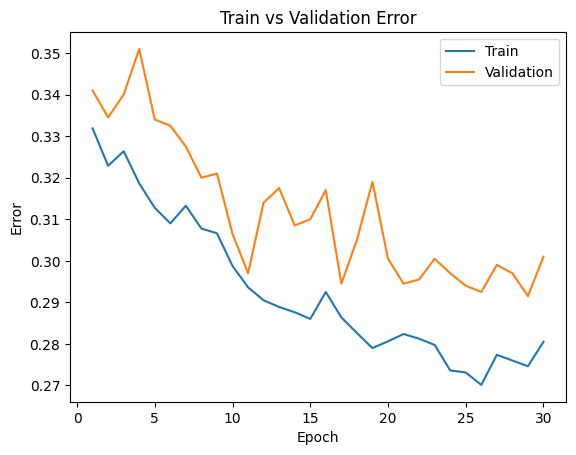

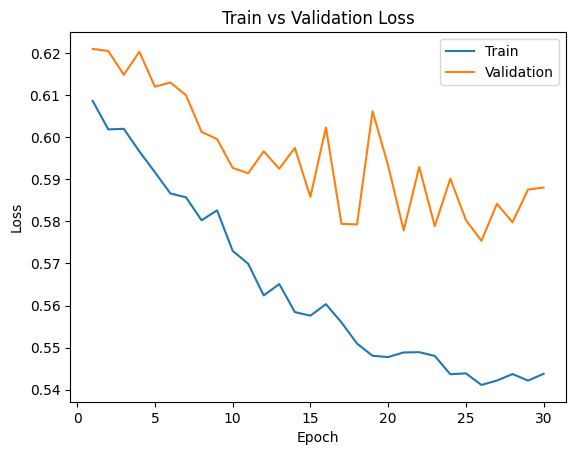

In [48]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
#print(get_model_name('small network', 64, 0.01, 5))

small_path = get_model_name('small', 64, 0.01, 29)
plot_training_curve(small_path)

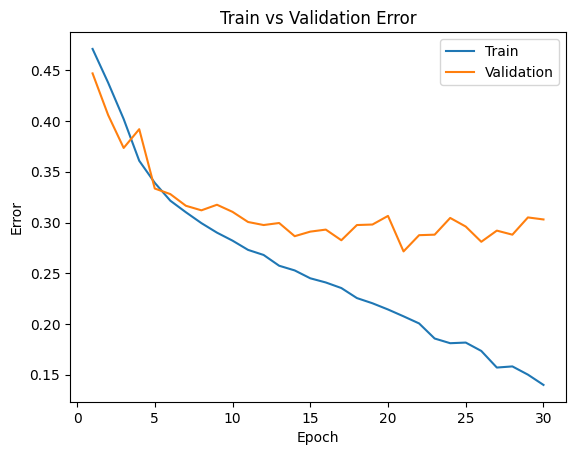

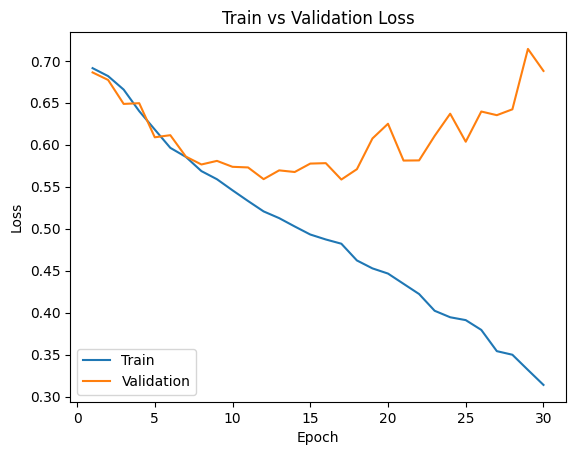

In [49]:
large_path = get_model_name('large', 64, 0.01, 29)
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [50]:
# For the small network, there are instances of underfitting because the training error and loss of the model
# do not particularly improve with more iterations. In contrast, there are instances of overfitting with the
# large network as the validation loss of this model increases while the training loss decreases (at epochs
# 17-30).

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

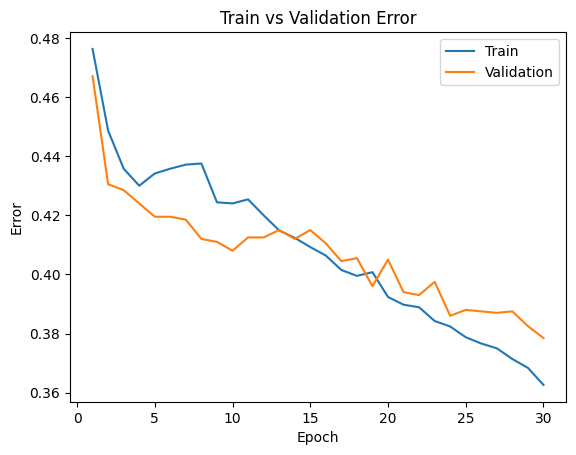

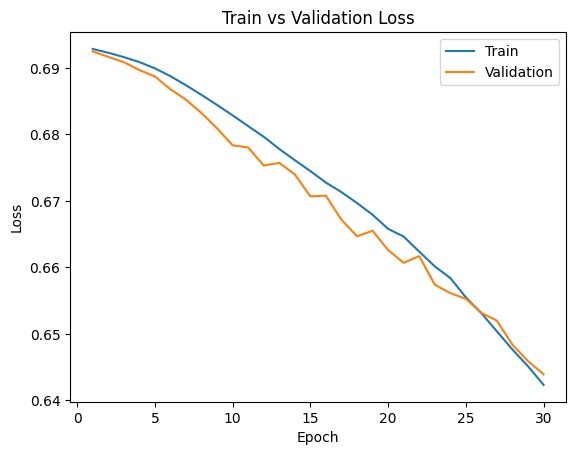

In [51]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)
large_path = get_model_name('large', 64, 0.001, 29)
plot_training_curve(large_path)

By lowering the learning rate to 0.001, the training time takes roughly the same amount of time in comparison to the default settings, taking 166 seconds.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

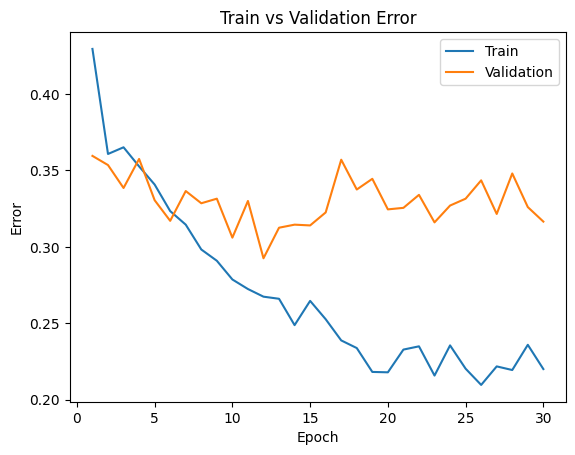

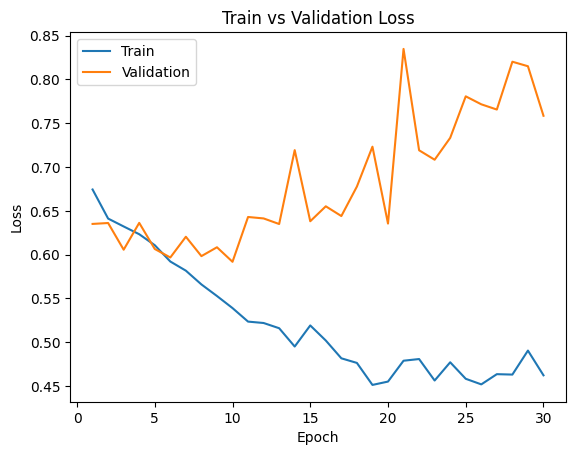

In [52]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
large_path = get_model_name('large', 64, 0.1, 29)
plot_training_curve(large_path)

The model took 164.97 seconds to run, which is close to the same time as the default training parameters. Also, the validation error and loss are both increasing mostly throughout the epochs, which is a sign of overfitting.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

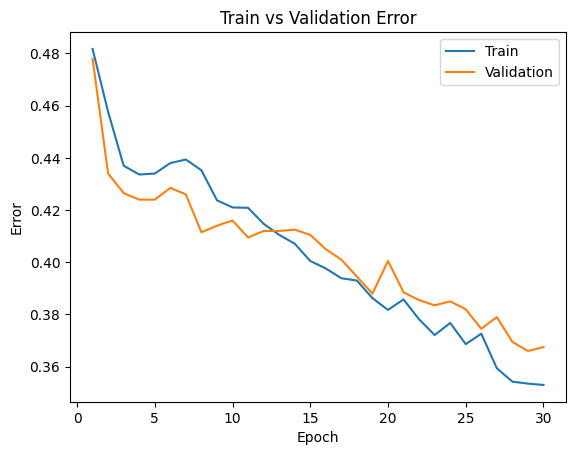

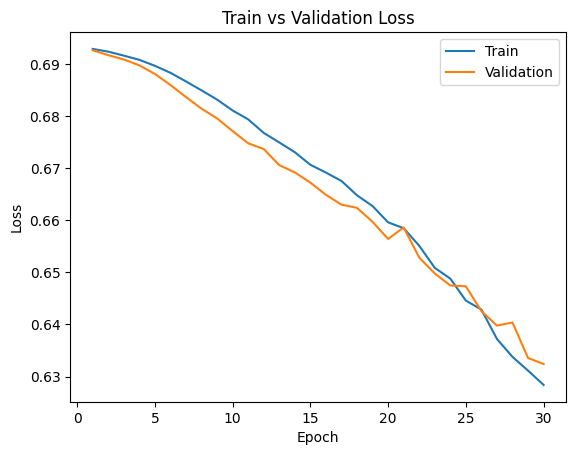

In [53]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
large_path = get_model_name('large', 512, 0.01, 29)
plot_training_curve(large_path)

Increasing the batch size to 512 decreases the runtime of the training by around 15 seconds with a runtime of 151.03 seconds. It will result in an occurrence of overfitting since the training loss decreases while the validation loss increases.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

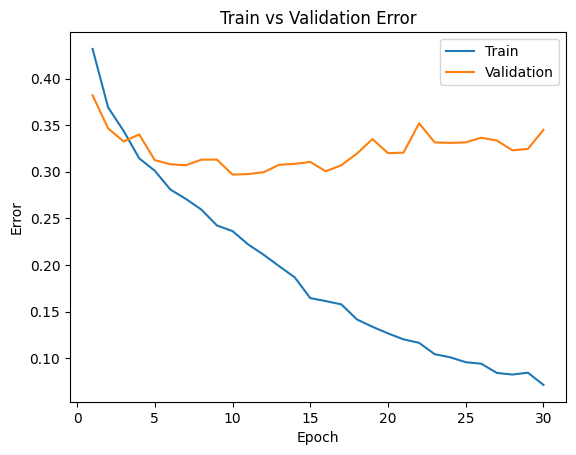

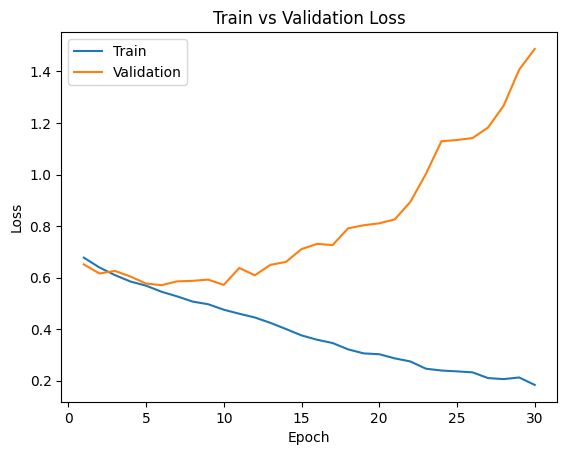

In [54]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
large_path = get_model_name('large', 16, 0.01, 29)
plot_training_curve(large_path)

The training error and loss are both decreasing throughout the 30 epochs, whereas the validation loss is sharply increasing throughout these 30 epochs. In addition, by decreasing the batch size, the runtime increases by almost a minute at 218.66 seconds.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the above plots, another set of hyperparameters would be to use a batch size of 512 and a learning rate of 0.001 in the large network size. This is because when the batch size is 512 and the learning rate is 0.001 (from above), it is able to reduce the occurrences of overfitting in comparison to batch size 16 or learning rate 0.1.

The reasoning for using the large network over the small network is because the large network less affected by noise.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

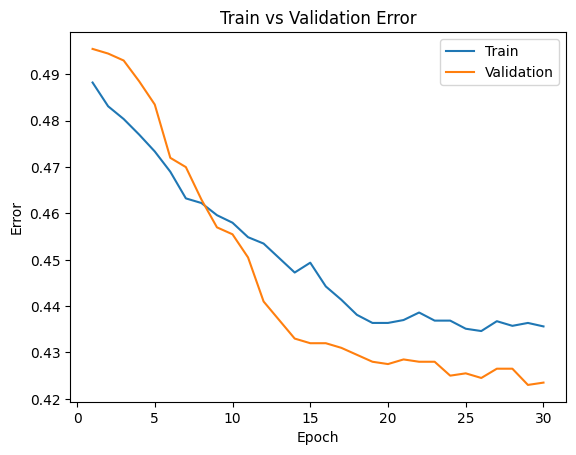

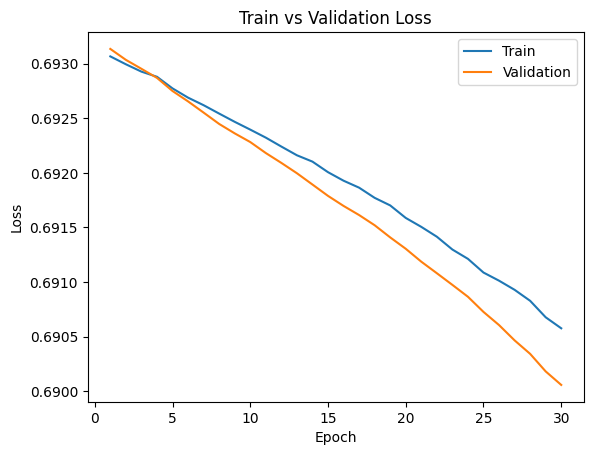

In [55]:
large_net = LargeNet()
train_net(large_net, 512, 0.001, 30)
new_model = get_model_name('large', 512, 0.001, 29)
plot_training_curve(new_model)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

The results from part a) takes into account overfitting as an issue, shown by the bottom graph. The new parameters that can be tried out are maintaining the 512 batches (since it seems to be working effectively) but lowering the iterations trained (to 20 epochs). This is because at ~epoch 15-20, the difference between the validation and training error/loss begins to deviate increasingly.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

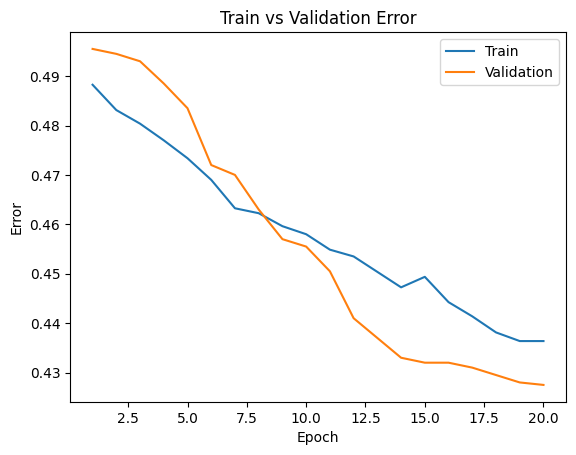

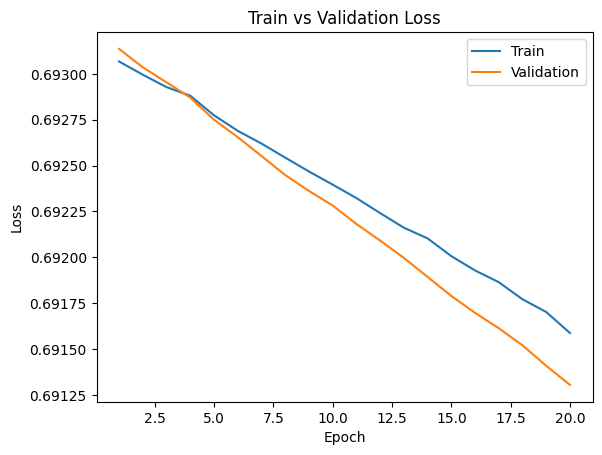

In [56]:
large_net = LargeNet()
train_net(large_net, 512, 0.001, 20)
new_model = get_model_name('large', 512, 0.001, 19)
plot_training_curve(new_model)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [57]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.01, epoch=20)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The reason for choosing a batch size of 512 is because in part 2, when increasing the batch size, it had reduced the effects of overfitting that were observed when using a batch size of 64.

The reason for choosing the large network over the small network is due to sheer number of parameters of the large network, it is less susceptible that the model will be affected by meaningless data, whereas meaningless data in a small network can potentially affect the performance of the model.

Finally, choosing to have 20 epochs was because it was noted in parts 3a and b that by the 20th epoch, the overfitting was beginning to become noticeable.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [58]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
loss_func = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, loss_func)
print(err, loss)

Files already downloaded and verified
Files already downloaded and verified
0.3785 0.65489462018013


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test classification error is 0.3785, whereas the validation error is 0.4275. This is interesting because we expect the validation error to be lower than the test classification error. When validating, the model is exposed to the validation dataset repeatedly to properly tune the hyperparameters, while this is the first time for the test classification dataset.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

It is important to use the test dataset only at the end because we want to simulate a brand-new dataset being tested. If, for example, the model was built with an understanding of the test set, it can result in unwanted biases.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [59]:
# ANN taken from Lab 1 but now with 3 color channels instead of 1:
class Pigeon(nn.Module):
    def __init__(self):
      # add a name to the NN so that it can be recognized by get_model_name
        self.name = ('pigeon')
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        # flattening to 1 dimension
        activation2 = activation2.squeeze(1)
        return activation2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4975, Train loss: 0.6948394626379013 |Validation err: 0.494, Validation loss: 0.6931356489658356
Epoch 2: Train err: 0.4685, Train loss: 0.6874800734221935 |Validation err: 0.4555, Validation loss: 0.6864997744560242
Epoch 3: Train err: 0.435875, Train loss: 0.6816162392497063 |Validation err: 0.4335, Validation loss: 0.6818910092115402
Epoch 4: Train err: 0.41825, Train loss: 0.6767737753689289 |Validation err: 0.4225, Validation loss: 0.6777995973825455
Epoch 5: Train err: 0.41325, Train loss: 0.6726087294518948 |Validation err: 0.416, Validation loss: 0.6743183135986328
Epoch 6: Train err: 0.406375, Train loss: 0.6696753986179829 |Validation err: 0.4125, Validation loss: 0.6714583188295364
Epoch 7: Train err: 0.404625, Train loss: 0.6670786738395691 |Validation err: 0.4105, Validation loss: 0.6694319099187851
Epoch 8: Train err: 0.400125, Train loss: 0.6648142598569393 |Validation err: 

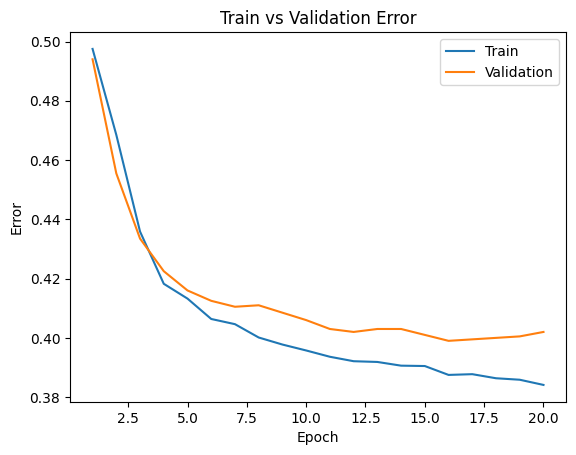

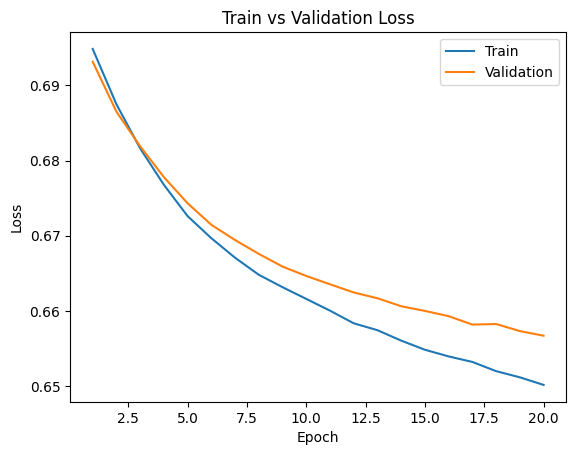

In [60]:
# loading the network
pigeon = Pigeon()

# training the model with the same parameters
train_net(pigeon, 512, 0.001, 20)
# plot results
ANN = get_model_name('pigeon', 512, 0.001, 19)
plot_training_curve(ANN)


In [61]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
loss_func = nn.BCEWithLogitsLoss()
err, loss = evaluate(pigeon, test_loader, loss_func)
print(err, loss)

Files already downloaded and verified
Files already downloaded and verified
0.38 0.6494937390089035


The performance of the 2 layer ANN on the test classification set is slightly worse than the CNN, with the error being 0.3805.